In [1]:
###### import packags
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [2]:
# test binary_quantization function
def binary_quantization(x):
    # x_back is the actual tensor for gradient computation
    # while sign(x) is the forwarded tensor
    # detach() can eliminate the gradient
    x_back = torch.clamp(x, -1, 1)
    return (torch.sign(x) - x_back).detach() + x_back


x = torch.tensor([0.4, -0.5, 1.6]).requires_grad_()
x_bin = binary_quantization(x)
# print the result after binarization
print(x_bin)
y = x_bin.sum()
y.backward()
# print the gradient of x
print(x.grad)

#Feeforwarding: quantize all positive numbers in tensor to 1, and negative numbers to -1,
#Backpropagation: results as the gradient of tensor is 1 in the range of -1 to 1, and the rest is 0

tensor([ 1., -1.,  1.], grad_fn=<AddBackward0>)
tensor([1., 1., 0.])


In [3]:
# test binary convolutional function
# define binary convolutional layer
class BinConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(BinConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups,
                                        bias)

    def forward(self, x):
        weight = binary_quantization(self.weight)
        return F.conv2d(x, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

# define a Binary convolution in input channel = 5，output channel = 10，kernelsize = 3
binary_conv = BinConv2d(5, 10, 3, 1)
print(binary_conv.weight.data)   # Print the value of convolution
print(binary_quantization(binary_conv.weight.data))   # Print the binarized convolution, in weight value

tensor([[[[-0.0372,  0.0549, -0.0146],
          [ 0.1056, -0.0581,  0.1103],
          [-0.0338, -0.0923, -0.0289]],

         [[-0.0779, -0.0049,  0.0964],
          [ 0.0847, -0.0364, -0.0876],
          [ 0.0906, -0.0513, -0.0765]],

         [[-0.1091, -0.0264,  0.0387],
          [-0.0352, -0.0145, -0.0646],
          [ 0.0448,  0.1037,  0.0030]],

         [[-0.0483,  0.0579,  0.1061],
          [ 0.1437, -0.0604, -0.1023],
          [ 0.1088, -0.1454, -0.0817]],

         [[-0.0568,  0.0379, -0.0997],
          [ 0.0092, -0.0136, -0.1254],
          [-0.0279,  0.0871, -0.1239]]],


        [[[-0.0647,  0.0777, -0.0253],
          [-0.1367,  0.1162,  0.0514],
          [-0.0803, -0.0061, -0.0370]],

         [[ 0.0755,  0.0176,  0.1163],
          [-0.1432, -0.1001, -0.1034],
          [-0.0126,  0.0075, -0.0054]],

         [[ 0.0034,  0.1260,  0.1113],
          [ 0.0187,  0.1089,  0.1166],
          [-0.0460,  0.0260, -0.0046]],

         [[ 0.1418,  0.0324, -0.0304],
       

In [4]:
# test binary fully-connected function
# define binary fully-connected layer
class BinLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(BinLinear, self).__init__(in_features, out_features, bias=True)

    def forward(self, x):
        weight = binary_quantization(self.weight)
        return F.linear(x, weight, self.bias)

# Define a binary fully connected layer with an input channel of 5 and an output channel of 10
binary_conv = BinLinear(5, 10)
print(binary_conv.weight.data)   # Print the value of this fully connected weight
print(binary_quantization(binary_conv.weight.data))   # Print the binarized weight

tensor([[ 0.1304, -0.1292,  0.0275, -0.3544, -0.4292],
        [-0.2722, -0.2451, -0.1060, -0.3585, -0.3061],
        [-0.3336, -0.2596,  0.3759, -0.3470, -0.2061],
        [ 0.0428, -0.3117,  0.1662, -0.0858,  0.2013],
        [-0.1835, -0.3415, -0.2589,  0.1170, -0.0849],
        [ 0.2892,  0.3331, -0.2601, -0.3168, -0.3874],
        [ 0.2796, -0.1383, -0.4007, -0.2742,  0.4123],
        [ 0.4027, -0.1929, -0.2911, -0.0935, -0.0592],
        [-0.2384, -0.1725, -0.1989, -0.1880,  0.0932],
        [-0.1660,  0.3736, -0.4236,  0.0472, -0.2426]])
tensor([[ 1., -1.,  1., -1., -1.],
        [-1., -1., -1., -1., -1.],
        [-1., -1.,  1., -1., -1.],
        [ 1., -1.,  1., -1.,  1.],
        [-1., -1., -1.,  1., -1.],
        [ 1.,  1., -1., -1., -1.],
        [ 1., -1., -1., -1.,  1.],
        [ 1., -1., -1., -1., -1.],
        [-1., -1., -1., -1.,  1.],
        [-1.,  1., -1.,  1., -1.]])


In [5]:
# define LogAP2 function
def LogAP2(x, eps=0.0):
    # implement Most Significant Bit according to the paper
    return torch.sign(x) * 2 ** (torch.round(torch.log2(x.abs() + eps)))

# The purpose of this function is to convert any floating-point number x to its nearest second power 2^n，
# That is, for any x, we find n such that the difference between the nth power of 2 and x is the smallest

x = torch.tensor([0.4, -0.5, 1.6])
print(LogAP2(x))

# When x is abnormally small, this function will overflow due to Log, so we add eps

tensor([ 0.5000, -0.5000,  2.0000])


In [6]:
class ShiftBatchNorm(nn.BatchNorm1d):
    def __init__(self, channel, *args):
        super(ShiftBatchNorm, self).__init__(channel, *args)

    def round_pass(self, x):
        # to make rounded tensor still have gradient
        return (x.round() - x) + x

    def LogAP2(self, x, eps=0.0):
        # implement Most Significant Bit according to the paper
        return torch.sign(x) * 2 ** (torch.round(torch.log2(x.abs() + eps)))

    def get_var(self, x, mean, channel_dim):
        # implement variance with LogAP2()
        centerd_mean = x - mean.reshape(1, channel_dim)
        variance = centerd_mean * self.LogAP2(centerd_mean, eps=0.0001)
        return variance.mean([0])

    def forward(self, input, round_var=True):
        # determine the average factor and channel dimension
        exponential_average_factor = self.momentum
        channel_dim = input.shape[1]
        # calculate running estimates if the model is in training
        if self.training:
            mean = input.mean([0])
            var = self.get_var(input, mean, channel_dim)

            # Update the running stats in Batch Normalization Layer
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean + (
                            1 - exponential_average_factor) * self.running_mean
                # update running_var with unbiased var
                self.running_var = exponential_average_factor * var + (
                            1 - exponential_average_factor) * self.running_var
        # In testing the model directly uses the running stats
        else:
            mean = self.running_mean
            var = self.running_var

        # calculate the normalization factor
        div = 1 / (torch.sqrt(var.reshape(1, channel_dim) + self.eps))
        if round_var:
            div = self.LogAP2(div)
        input = (input - mean.reshape(1, channel_dim)) * div  # normalize
        return input
    

# Initialize the BatchNorm layer（channel=64）
bn = ShiftBatchNorm(64)

# Randomly create activation (Batchsize=1024, channel=64)
x = torch.randn(1024, 64)

# turn the average of activation to 3，variation to 9
x = x * 3 + 3

# Test the performance of BN
y = bn(x)
# Seperately print the results of average and var
print(y.mean(0))
print(y.var(0))
# The reason why the variance of this is not 1 is that it was originally meant to be divided by 0.333, 
# but the LogAP2 function changed the number to be divided into 0.25, so the variance is not.
# I set a parameter round_var, when it is set to False, the variance can be close to 1:
y = bn(x, round_var=False)
print(y.var(0))

tensor([ 1.1176e-08, -4.5169e-08, -1.5832e-08,  1.8626e-09, -3.7253e-09,
        -2.4214e-08, -1.9558e-08,  7.4506e-08,  9.3831e-08, -5.9605e-08,
        -2.0489e-08, -2.4214e-08, -6.5193e-09, -3.2131e-08,  1.5367e-08,
        -1.2107e-08, -7.4971e-08,  1.8161e-08, -2.6077e-08, -5.4541e-08,
        -2.9802e-08, -1.3039e-08, -1.1292e-08, -8.8476e-09, -2.5146e-08,
         1.6298e-08,  6.0536e-09,  7.4506e-09,  8.3819e-09,  2.7940e-09,
         1.3039e-08,  1.4901e-08, -3.4692e-08, -2.0023e-08, -4.2841e-08,
         0.0000e+00,  1.0361e-08,  6.9849e-10, -1.2107e-08,  3.7951e-08,
         2.8871e-08,  3.5390e-08, -1.4901e-08,  2.8871e-08,  1.4901e-08,
        -2.7940e-08,  1.3737e-08, -2.9104e-09,  1.3039e-08,  6.7288e-08,
        -4.8429e-08,  2.4564e-08,  3.3528e-08,  6.7521e-08, -7.4506e-09,
        -3.3760e-09,  5.6811e-08,  7.9162e-09, -1.0245e-08,  3.0501e-08,
         6.7055e-08,  9.3132e-10, -5.8208e-08,  1.5832e-08])
tensor([0.5437, 0.5397, 0.5266, 0.6047, 0.5262, 0.5908, 0.5116,

In [7]:
class TinyModel(nn.Module):

    def __init__(self, binarized=True, res=32, rgb=False):
        super().__init__()
        # define network structures
        # if binarized is set to True,
        # we use binary linear layer and
        # shift batchnorm layer.
        mult = 3 if rgb is True else 1
        if binarized is True:
            self.conv1 = BinLinear(res * res * mult, 2048)
            self.bn1 = ShiftBatchNorm(2048)
            self.conv2 = BinLinear(2048, 2048)
            self.bn2 = ShiftBatchNorm(2048)
        else:
            self.conv1 = nn.Linear(res * res * mult, 2048)
            self.bn1 = nn.BatchNorm1d(2048)
            self.conv2 = nn.Linear(2048, 2048)
            self.bn2 = nn.BatchNorm1d(2048)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2048, 10)

    def forward(self, x):
        # Standard Conv-BN-Act block, note that the
        # activation is not binarized for the first layer
        # according to Section 2.6 in the paper.
        x = x.view(x.size(0), -1)
        x = self.conv1(x)
        x = self.bn1(x)
        # Binarize activation
        x = binary_quantization(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = binary_quantization(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = TinyModel()
print(model)

TinyModel(
  (conv1): BinLinear(in_features=1024, out_features=2048, bias=True)
  (bn1): ShiftBatchNorm(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): BinLinear(in_features=2048, out_features=2048, bias=True)
  (bn2): ShiftBatchNorm(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)


In [8]:
# Model Complexity：

# Full Precision Model

# count the number of parameter
num_param = sum([i.numel() for i in model.parameters()])

# turn number of parameter into megabyte:  
# *Floating point number 32 bits / 8 bits per byte / 1024 bytes to kB / 1024 bytes to MB
MBs = num_param * 32 / 8 / 1000 / 1000
print('The storage of FP model is {}.MB'.format(MBs))

# The parameter of the binary network is 1/32 of the original network, because it only takes up one bit。
print('The storage of binary model is {}.MB'.format(MBs/32))

The storage of FP model is 25.296936000000002.MB
The storage of binary model is 0.7905292500000001.MB


In [9]:
def train(model, device, train_loader, optimizer, epoch):
    """
    Training function for binary model
    :param model: the binary model that needs to be optimized
    :param device: usually GPU with cuda
    :param train_loader: data loader of training dataset
    :param optimizer: Adam optimizer
    :param epoch: current training epoch
    :return: trained model
    """
    model.train()
    # start training iterating
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # forward, compute loss, backward, update loop
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
    return

In [10]:
def test(model, device, test_loader):
    """
    Test function for binary model
    :param model: the binary model that needs to be tested
    :param device: usually GPU with cuda
    :param test_loader: data loader of testing dataset
    :return:
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  # no gradient signal during testing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


# set the random seed for reproducibility
seed = 1001
torch.manual_seed(seed)

device = torch.device("cuda")

train_kwargs = {'batch_size': 128}
test_kwargs = {'batch_size': 100}

cuda_kwargs = {'num_workers': 1,
               'pin_memory': True,
               'shuffle': True}


In [14]:
# --------------------------Preparing Dataset ----------------------
# Dataset can be chosed from CIFAR10, MNIST, and SVHN
Dset = 'MNIST'
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

if Dset == 'MNIST':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset1 = datasets.MNIST('data', train=True, download=True,
                              transform=transform)
    dataset2 = datasets.MNIST('data', train=False,
                              transform=transform)
    res = 28
    rgb = False
elif Dset == 'SVHN':
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    dataset = datasets.SVHN('data', download=True, transform=transform)
    from torch.utils.data import random_split

    val_size = 5000
    random_seed = 42
    torch.manual_seed(random_seed)
    train_size = len(dataset) - val_size
    dataset1, dataset2 = random_split(dataset, [train_size, val_size])
    res = 32
    rgb = True
elif Dset == 'CIFAR':
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    dataset1 = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    dataset2 = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

    res = 32
    rgb = True

train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [15]:
# prepare model
model = TinyModel(False, res, rgb)
model.cuda()  # we use cuda default
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# training for 30 epochs
epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, )

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
    
    
#for this step, if running code in macOS, might given error; but in windows might not.
#there is special situation for CUDA used in different system

AssertionError: Torch not compiled with CUDA enabled

In [12]:
#Here is figure part
# import packages
import numpy as np
from matplotlib import pyplot as plt

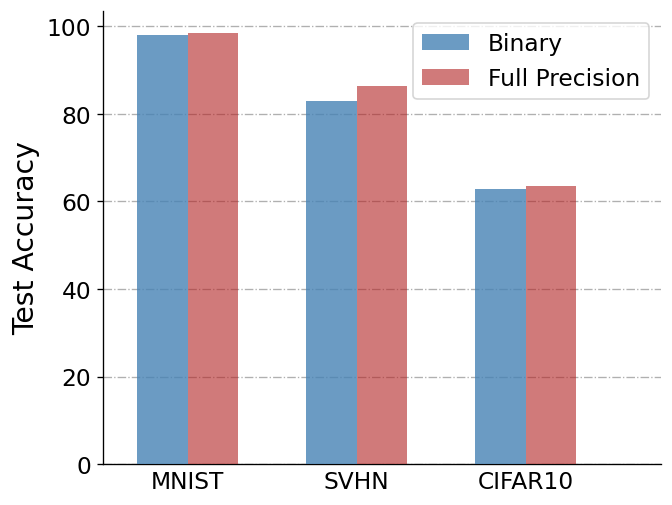

In [13]:
# total 3 bars (MNIST, SVHN, CIFAR10)
N = 3

# setup color names
color1 = 'firebrick'
color2 = 'steelblue'
color3 = 'darkcyan'
color4 = 'darkorange'

# test accuracy obtained from `test.py`,
# bar1 is the model been binarized, while
# bar2 is the 32-bit floating-point model
bar1 = [98.04, 83.02, 62.94]
bar2 = [98.52, 86.42, 63.62]

# setup figure,
fig = plt.figure(dpi=120, figsize=[6, 5])
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)
# only one plot here
ax = plt.subplot(111)
# setup grid in y axis for better visualization
ax.grid('on', axis='y', linestyle='-.', zorder=0)
ind = np.arange(1, N+1)    # the x locations for the groups
width = 0.3         # the width of the bars
# plot histogram
p1 = ax.bar([i-0.5*width for i in ind], bar1, width, bottom=0, zorder=3, color=color2, alpha=0.8)
p2 = ax.bar([i+0.5*width for i in ind], bar2, width, zorder=3, color=color1, alpha=0.6)
# remove top right axis for better results
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')

# plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(axis='x', which='both', length=0)
# setup x axis tick label
ax.set_xticks(range(1, 4))
ax.set_xticklabels(['MNIST', 'SVHN', 'CIFAR10'])
ax.set_xlim(0.5, 3.8)
ax.set_ylabel('Test Accuracy', fontsize=17)
ax.legend((p1[0], p2[0]), ('Binary', 'Full Precision'), prop={'size': 14})
plt.show()